In [1]:
from max_reward_buffer import ReplayBuffer
import os
from energies import *
from plot_utils import *
from utils import set_seed, cal_subtb_coef_matrix, fig_to_image, get_gfn_optimizer, get_gfn_forward_loss, \
    get_gfn_backward_loss, get_exploration_std, get_name

In [11]:
buffer = ReplayBuffer(600000, device='cuda', coreset_size=30000, exploration_mode=True)


In [17]:
buffer.load_buffer('../buffer_np/buffer_many_well_16000_1725028230.7593646.npy')

In [18]:
#buffer.set_prioritization()
buffer.get_core_set()

In [19]:
buffer.real_size

30000

In [9]:
energy_name = "many_well"

def get_energy(energy_name, device):
    if energy_name == '9gmm':
        energy = NineGaussianMixture(device=device)
    elif energy_name == '25gmm':
        energy = TwentyFiveGaussianMixture(device=device)
    elif energy_name == 'hard_funnel':
        energy = HardFunnel(device=device)
    elif energy_name == 'easy_funnel':
        energy = EasyFunnel(device=device)
    elif energy_name == 'many_well':
        energy = ManyWell(device=device)
    return energy

energy = get_energy(energy_name, 'cpu')

In [8]:
def plot_step(energy, energy_name,  samples, device = 'cpu'):

    # Visualization 및 파일 저장
    if energy_name == 'many_well':
        vizualizations = viz_many_well(energy, samples)
        fig_samples_x13, ax_samples_x13, fig_kde_x13, ax_kde_x13, fig_contour_x13, ax_contour_x13, fig_samples_x23, ax_samples_x23, fig_kde_x23, ax_kde_x23, fig_contour_x23, ax_contour_x23 = vizualizations

        fig_samples_x13.savefig(f'samplesx13.pdf', bbox_inches='tight')
        fig_samples_x23.savefig(f'samplesx23.pdf', bbox_inches='tight')

        fig_kde_x13.savefig(f'kdex13.pdf', bbox_inches='tight')
        fig_kde_x23.savefig(f'kdex23.pdf', bbox_inches='tight')

        fig_contour_x13.savefig(f'contourx13.pdf', bbox_inches='tight')
        fig_contour_x23.savefig(f'contourx23.pdf', bbox_inches='tight')

    else:
        fig_contour, ax_contour = get_figure(bounds=(-13., 13.))
        fig_kde, ax_kde = get_figure(bounds=(-13., 13.))
        fig_kde_overlay, ax_kde_overlay = get_figure(bounds=(-13., 13.))

        plot_contours(energy.log_reward, ax=ax_contour, bounds=(-13., 13.), n_contour_levels=150, device=device)
        plot_kde(samples, ax=ax_kde_overlay, bounds=(-13., 13.))
        plot_kde(samples, ax=ax_kde, bounds=(-13., 13.))
        plot_samples(samples, ax=ax_contour, bounds=(-13., 13.))
        plot_samples(samples, ax=ax_kde_overlay, bounds=(-13., 13.))

        fig_contour.savefig(f'contour.pdf', bbox_inches='tight')
        fig_kde_overlay.savefig(f'kde_overlay.pdf', bbox_inches='tight')
        fig_kde.savefig(f'kde.pdf', bbox_inches='tight')


In [22]:
samples = buffer.buffer
rewards = buffer.true_rewards

In [ ]:
rewards[rewards > 95]

array([ 96.842804,  95.59274 ,  97.44603 , 100.55438 ,  95.42912 ,
        99.48037 ,  95.29561 ,  97.901474,  98.67675 ,  98.45775 ,
        96.63989 ,  97.87875 ,  98.0863  ,  97.51199 ,  96.0334  ,
        99.705826,  95.29401 ,  96.303986,  99.07677 ,  97.49758 ,
        96.73763 , 114.09386 ,  95.429016,  98.54323 ,  97.2648  ,
        98.39993 ,  97.24609 , 100.84802 ,  98.814575,  98.12026 ,
        95.41872 ,  96.34042 ,  96.1543  ,  96.17453 ,  96.005035,
        95.96158 ,  96.98134 ,  96.013916,  95.568504, 103.72656 ,
        97.71225 ,  97.18663 ,  96.66873 ,  96.6526  ,  97.142784,
        97.83394 ,  97.46452 ,  98.20403 ,  97.856995,  95.5764  ,
       110.344696,  95.57956 ,  97.70652 ,  96.370544,  95.18692 ,
        95.12079 , 101.86232 ,  96.47388 ,  98.28588 , 100.31788 ,
        98.61718 ,  97.48561 , 105.93524 ,  96.54936 ,  97.57822 ,
        99.09378 ,  98.58812 ,  95.54696 ,  98.7537  ,  96.72558 ,
        99.97854 ,  96.81427 , 102.37652 ,  97.70859 ,  95.329

In [ ]:
rewards.max()

np.float32(114.09386)

In [ ]:
import torch
import numpy as np

# 히스토그램의 bin 개수
num_bins = 100

# 각 샘플의 intrinsic reward를 저장할 리스트
intrinsic_rewards = []

# 각 디멘젼별로 히스토그램을 계산하고, 각 샘플에 대해 히스토그램 밀도를 합산
for i in range(buffer.buffer.shape[1]):  # 각 디멘젼에 대해 반복
    # 해당 디멘젼의 데이터 추출
    dimension_data = buffer.buffer[:, i]
    
    # 히스토그램 계산
    hist, bin_edges = np.histogram(dimension_data, bins=num_bins, density=True)
    
    # 각 샘플의 bin에 해당하는 밀도를 계산하여 intrinsic reward로 사용
    bin_indices = np.digitize(dimension_data, bin_edges[:-1], right=True)
    
    # 각 샘플의 밀도값 더하기
    rewards_for_dimension = hist[bin_indices - 1]  # bin_indices는 1-based 이므로 -1 필요
    if i == 0:
        intrinsic_rewards = rewards_for_dimension
    else:
        intrinsic_rewards += rewards_for_dimension

# intrinsic reward를 tensor로 변환
intrinsic_rewards = torch.tensor(intrinsic_rewards)

print(intrinsic_rewards[:10])  # 첫 10개의 intrinsic reward 출력



tensor([6.5895, 6.4646, 6.7541, 6.4812, 6.5161, 6.2602, 6.5209, 6.3976, 6.6909,
        6.2402], dtype=torch.float64)


In [ ]:
low_intrinsic_reward_indices = intrinsic_rewards.argsort()[:30000]

In [ ]:
density_rank_based_probability = 1 - (intrinsic_rewards / intrinsic_rewards.sum())

In [ ]:
# 상위 50%의 reward만 남기고 drop
percentage = int(len(rewards) * 0.1)

top_50_true_rewards = rewards[rewards.argsort()[-percentage:]]
top_50_samples = samples[rewards.argsort()[-percentage:]]
top_50_intrinsics = intrinsic_rewards[rewards.argsort()[-percentage:]]


In [ ]:
low_density_indices = np.argsort(top_50_intrinsics)[:30000]

NameError: name 'top_50_intrinsics' is not defined

In [ ]:
high_reward_indices = np.argsort(top_50_true_rewards)[-2000:]

In [ ]:
intrinsic_rewards.shape

torch.Size([599999])

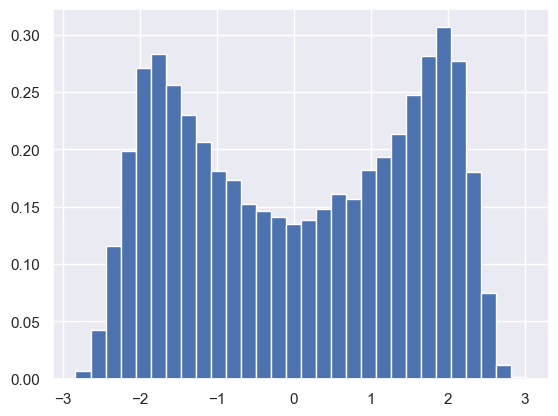

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def min_max_norm(x):
    return (x - x.min()) / (x.max() - x.min())




x = np.array(samples)[:, 30]
hist = plt.hist(x, bins=30, density = True)

In [ ]:
sampled_indices = np.random.choice(len(intrinsic_rewards), 100, p=x, replace=False)

In [ ]:
torch.softmax(-intrinsic_rewards, dim=0).max()

tensor(7.0830e-06, dtype=torch.float64)

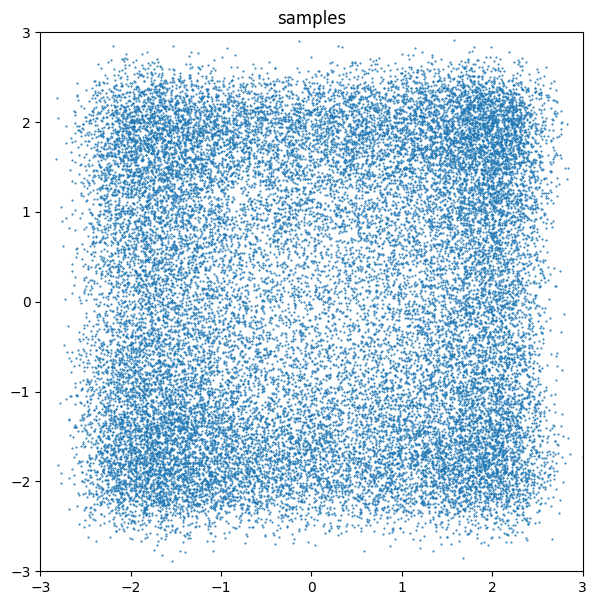

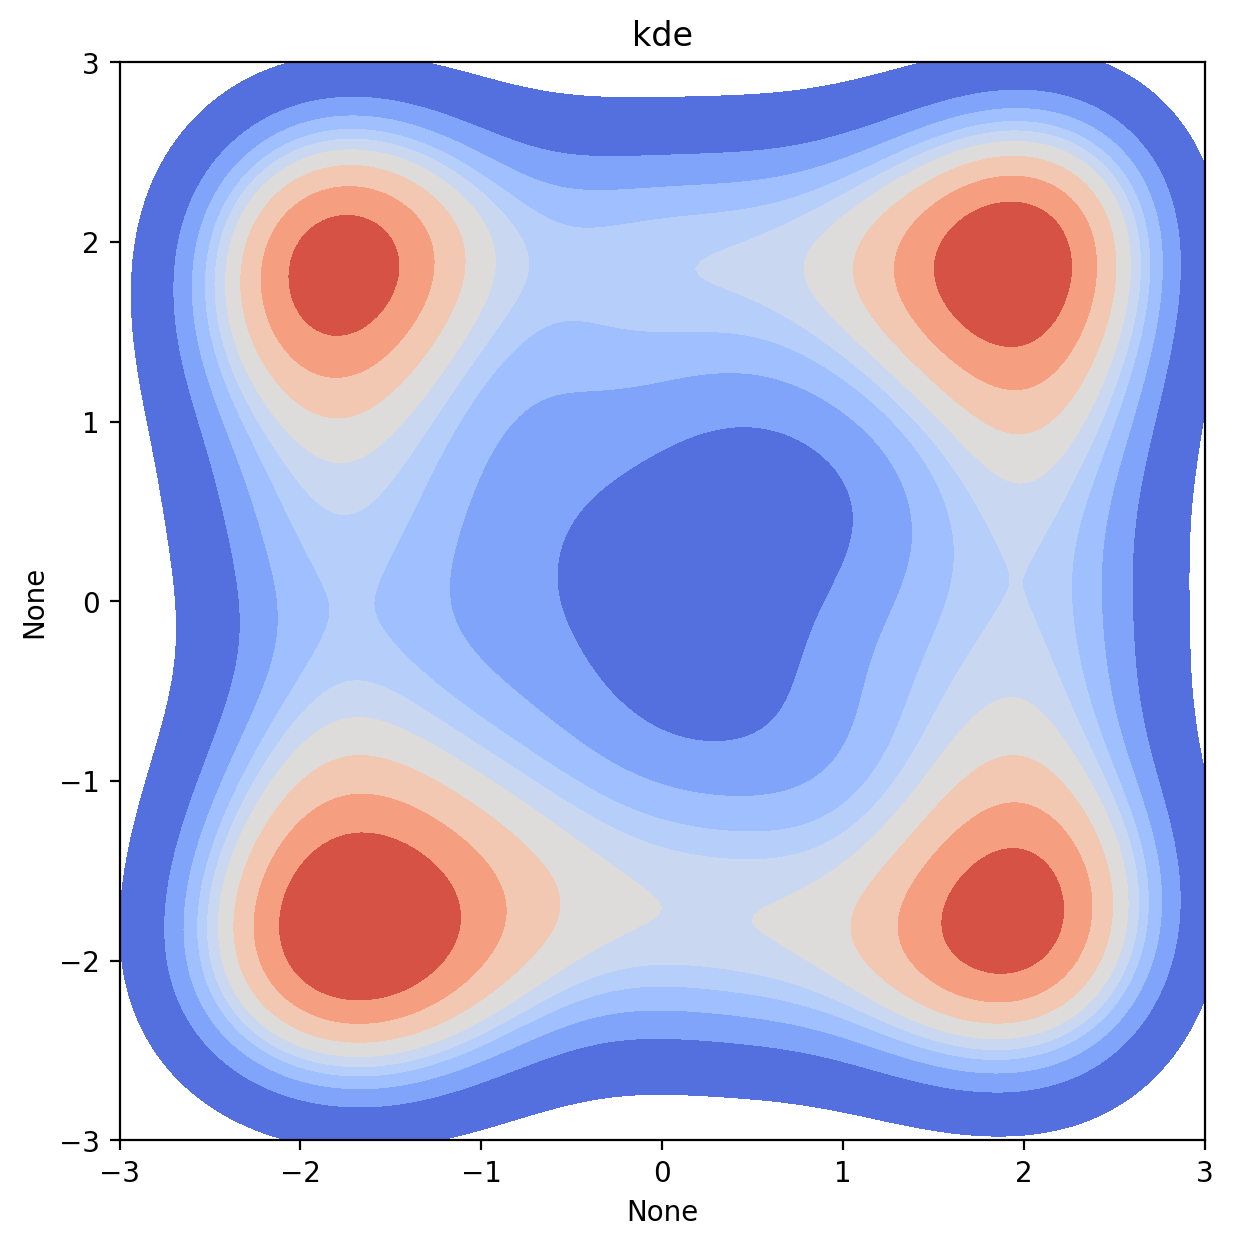

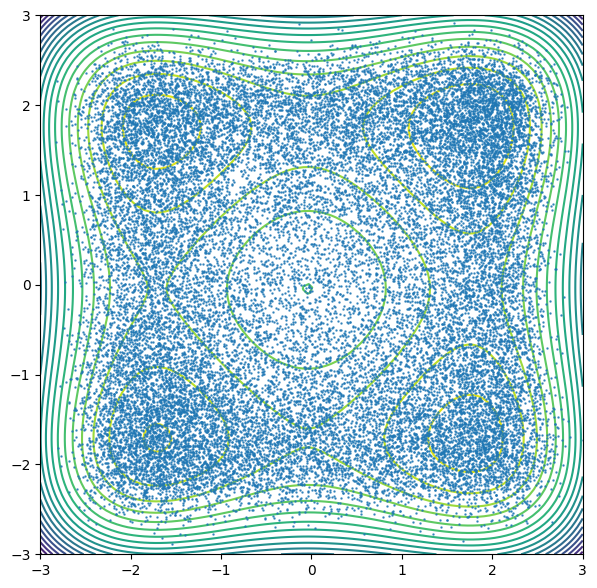

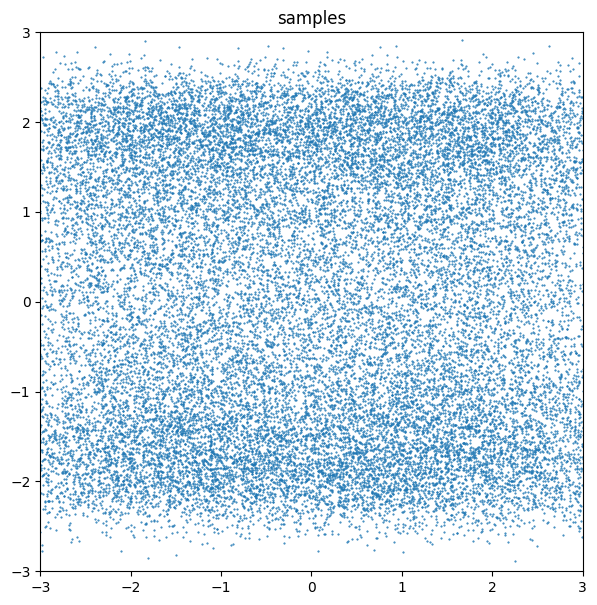

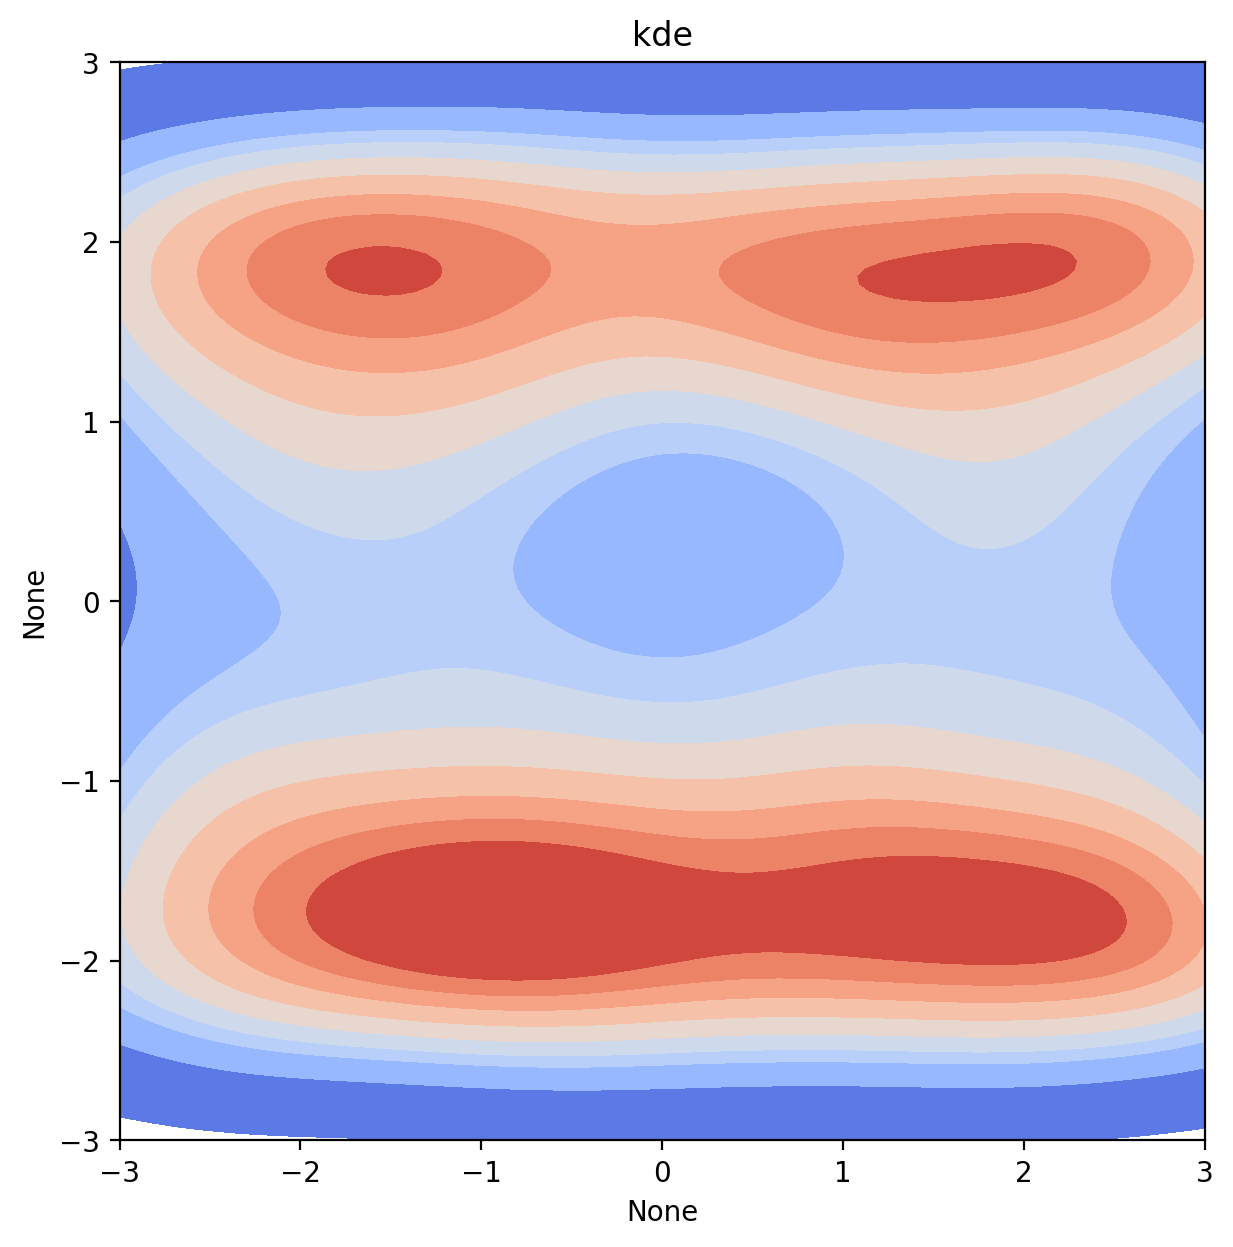

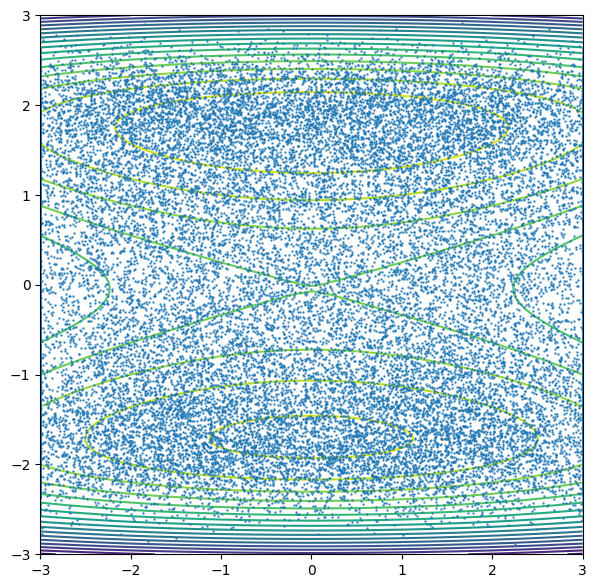

In [20]:

plot_step(energy, energy_name, torch.tensor(buffer.buffer).to('cuda'))

In [ ]:
# density estimation
from sklearn.neighbors import KernelDensity, NearestNeighbors

In [ ]:
KDE = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(buffer.buffer)
NN = NearestNeighbors(n_neighbors=30).fit(buffer.buffer)

In [ ]:



samples_prioritized_np = samples.cpu().numpy()

# NearestNeighbors를 사용하여 밀도 추정 학습
NN = NearestNeighbors(n_neighbors=100).fit(samples_prioritized_np)

## 2. Prioritization을 끄고 새 샘플에서 밀도를 계산
#buffer.prioritization = False
#samples, rewards = buffer.sample(2000)
#samples_np = samples.cpu().numpy()

# 이전에 학습된 NN 모델을 사용하여 새 샘플의 밀도 추정
distances, _ = NN.kneighbors(samples_prioritized_np)

# 밀도 계산 (평균 거리의 음수 로그 또는 다른 적절한 방식으로 밀도화)
log_densities = -torch.tensor(distances.mean(axis=1)).to('cuda')


ValueError: too many values to unpack (expected 2)

In [ ]:
# low 10% 밀도의 샘플을 찾아냄
low_density_samples = samples_prioritized[log_densities < torch.quantile(log_densities, 0.005)]


In [ ]:
# top 100 samples
#top_indices = np.argsort(rewards)[-300:]
# 100보다 큰 indices
top_indices = np.where(rewards > 90)[0]
print(rewards[top_indices], min(rewards[top_indices]), max(rewards[top_indices]))
top_samples = samples[top_indices]

[ 91.00859   91.45906   92.07957   92.2758    91.57106   93.08852
  96.842804  95.59274   90.968956  97.44603   92.29268   90.1514
 100.55438   91.348366  92.33392   91.681206  92.068665  91.93692
  92.10161   95.42912   91.58542   93.37685   91.22604   99.48037
  90.0163    92.49324   95.29561   97.901474  90.69986   92.421265
  92.77348   92.7685    93.85191   98.67675   91.3736    93.678406
  90.864655  91.35075   90.52242   90.632164  90.340775  92.868484
  93.73662   98.45775   94.02457   96.63989   91.78783   92.87297
  90.077515  92.725204  97.87875   94.19498   91.98813   92.99044
  98.0863    92.58328   94.021774  92.81052   91.24606   90.438385
  90.26883   90.17816   94.37413   92.95999   90.165276  92.98767
  92.05458   90.72157   93.21717   91.24376   97.51199   94.375244
  96.0334    99.705826  90.44545   93.41176   95.29401   94.00934
  93.26908   93.6909    90.00046   90.66164   96.303986  99.07677
  93.02707   97.49758   96.73763   90.864204  92.43216   93.13066
 114.0